In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import signal
from sklearn.cluster import KMeans
import scipy as sp
from scipy.io import loadmat
import copy
from scipy import linalg

sns.set_style('whitegrid')
%matplotlib inline

## Task 1: Generate toy data

Sample 1000 data points from a two dimensional mixture of Gaussian model with three clusters  and the following parameters:

$\mu_1 = \begin{bmatrix}0\\0\end{bmatrix}, \Sigma_1 = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}, \pi_1=0.3$

$\mu_2 = \begin{bmatrix}5\\1\end{bmatrix}, \Sigma_2 = \begin{bmatrix}2 & 1\\1 & 2\end{bmatrix}, \pi_2=0.5$

$\mu_3 = \begin{bmatrix}0\\4\end{bmatrix}, \Sigma_3 = \begin{bmatrix}1 & -0.5\\-0.5 & 1\end{bmatrix}, \pi_3=0.2$

Plot the sampled data points and indicate in color the cluster each point came from. Plot the cluster means as well.

In [3]:
def sampleData(N, m, S, p):
#    Generate N samples from a Mixture of Gaussian distribution with
#    means m, covariances S and priors p. The function returns the sampled
#    datapoints x as well as an indicator for the cluster the point 
#    originated from. The number of samples is rounded to the nearest integer.
#
#    m     #components x #dim
#    S     #dim x #dim x #components
#    p     #components
#
#    x     N x #dim
#    ind   N 

    samples = np.random.uniform(0,1,N)
    p = np.cumsum(p)

    x = []
    ind = []
    
    for i in range(N):
        for j, pi in enumerate(p):
            if samples[i]<pi:
                x.append(np.random.multivariate_normal(m[j],S[j]))
                ind.append(j)
                break
                
    
    return (np.array(x),np.array(ind))    


Specify parameters of Gaussians and generate data.

In [4]:
N = 1000
m = np.array([[0, 0], [5, 1], [0, 4]])
S1 = np.array([[1, 0], [0, 1]])
S2 = np.array([[2, 1], [1, 2]])
S3 = np.array([[1, -.5], [-.5, 1]])
S = np.concatenate((S1,S2,S3)).reshape(3,2,2)
p = np.array([.3, .5, .2])

np.random.seed(seed=2)
x, ind = sampleData(N, m, S, p)

print(x.shape)
unique, counts = np.unique(ind, return_counts=True)
print(dict(zip(unique, counts)))


(1000, 2)
{0: 307, 1: 500, 2: 193}


Plot the generated dataset

(-4.0, 10.0)

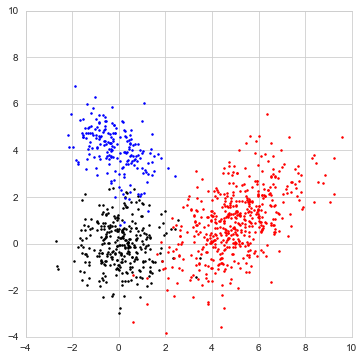

In [5]:
plt.figure(figsize=(6, 6))

ax = plt.subplot(1,1,1, aspect='equal')
plt.plot(x[ind==0,0],x[ind==0,1],'.k', markersize=3) 
plt.plot(x[ind==1,0],x[ind==1,1],'.r', markersize=3) 
plt.plot(x[ind==2,0],x[ind==2,1],'.b', markersize=3)

plt.xlim((-4,10))
plt.ylim((-4,10))

## Task 2: Implement a Gaussian mixture model

Implement the EM algorithm to fit a Gaussian mixture model in `mog()`.  Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. Test it on the toy dataset specifying the correct number of clusters and make sure the code works correctly. Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model.

In [7]:
from sklearn.mixture import GaussianMixture
#Using sklearn
def mog_sklearn(x,k):
# Fit Mixture of Gaussian model
#   ind, m, S, p = mog(x,k) fits a Mixture of Gaussian model to the data in
#   x using k components. The output ind contains the MAP assignments of the
#   datapoints in x to the found clusters. The outputs m, S, p contain
#   the model parameters.
#
#   x:     N by D
#
#   ind:   N by 1
#   m:     k by D
#   S:     D by D by k
#   p:     k by 1
    gm = GaussianMixture(n_components=k, random_state=0).fit(x)
    ind = gm.predict(x)
    m = gm.means_
    S = gm.covariances_
    p = gm.weights_

    return (ind, m, S, p)

In [8]:
from scipy.stats import multivariate_normal
#Own implementation
def mog(x,k):
# Fit Mixture of Gaussian model
#   ind, m, S, p = mog(x,k) fits a Mixture of Gaussian model to the data in
#   x using k components. The output ind contains the MAP assignments of the
#   datapoints in x to the found clusters. The outputs m, S, p contain
#   the model parameters.
#
#   x:     N by D
#
#   ind:   N by 1
#   m:     k by D
#   S:     D by D by k
#   p:     k by 1
    #Init parameters
    N = x.shape[0]
    D = x.shape[-1]
    p = np.ones((k,)) / k  
    m = x[np.random.choice(N, size = k),:]
    N_k = np.ones((k,))
    ind_old = 1000 * np.zeros((N,)) 
    max_val = np.max(x)
    min_val = np.min(x)
    
    
    #random covariance matrix
    s = np.random.normal(0, max_val, size=(D, D))
    S = np.dot(s, s.transpose())
    for i in range(k-1):
        s = np.random.normal(0, max_val, size=(D, D))
        mat = np.dot(s, s.transpose())
        S = np.concatenate((S,mat))
    S = S.reshape(k,D,D)

    changed = True
    counter = 0
    #repeat until cluster assignment changes
    while(changed):
        y_new = []

        #E-step
        for kn in range(k):
            y_list = []
            for xn in x:
                y_new_numerator = p[kn] * multivariate_normal.pdf(xn, mean=m[kn], cov=S[kn])
                y_new_denominater = 0
                for j in range(k):
                    y_new_denominater += p[j] * multivariate_normal.pdf(xn, mean=m[j], cov=S[j])
                y_new_div = y_new_numerator / y_new_denominater
                y_list.append(y_new_div)
            y_new.append(np.asarray(y_list))
        y_new = np.asarray(y_new)
        ind = np.argmax(y_new,axis=0).reshape((N,))
        
        #M-step
        N_k = np.sum(y_new,axis=1)
        for i in range(k):
            n_div = (1/N_k[i])
            m[i] = n_div * np.sum(y_new[i].reshape((N,1)) * x,axis=0)
            
            mean_deviations = x - m[i, :]
            S_temp = np.zeros((D,D))
            for j in range(N):
                S_temp += y_new[i,j] * np.outer(mean_deviations[j, :],mean_deviations[j, :])
            S[i,:,:] = 1 / N_k[i] * S_temp
            
            p[i] = N_k[i] / N

        if (ind_old==ind).all():
            changed = False
        ind_old = ind
                
        counter += 1
        if counter%10 == 0 or counter==1:
            print('iteration: {0}'.format(counter))
        
    print('Finished with iteration: {0}'.format(counter))

    return (ind, m, S, p)


Run mixture model on the dataset

In [9]:
np.random.seed(seed=5)
ind2, m, S, p = mog(x,3)

iteration: 1
iteration: 10
iteration: 20
iteration: 30
iteration: 40
Finished with iteration: 41


Plot assigned labels and original labels

(1000,)


Text(0.5, 1.0, 'MoG labels')

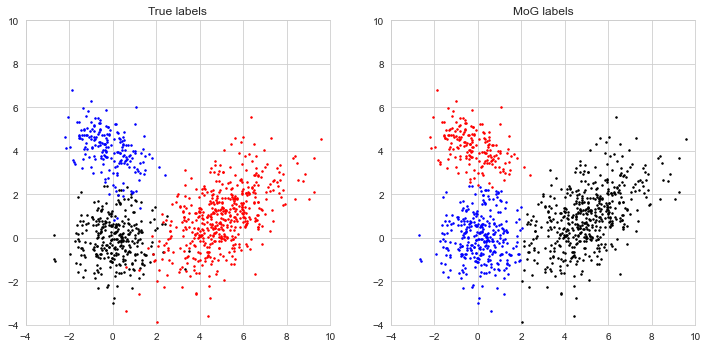

In [10]:
print(ind2.shape)

plt.figure(figsize=(12, 6))

ax = plt.subplot(1,2,1, aspect='equal')
plt.plot(x[ind==0,0],x[ind==0,1],'.k', markersize=3) 
plt.plot(x[ind==1,0],x[ind==1,1],'.r', markersize=3) 
plt.plot(x[ind==2,0],x[ind==2,1],'.b', markersize=3)

plt.xlim((-4,10))
plt.ylim((-4,10))
plt.title('True labels')

ax = plt.subplot(1,2,2, aspect='equal')
plt.plot(x[ind2==0,0],x[ind2==0,1],'.k', markersize=3) 
plt.plot(x[ind2==1,0],x[ind2==1,1],'.r', markersize=3) 
plt.plot(x[ind2==2,0],x[ind2==2,1],'.b', markersize=3)

plt.xlim((-4,10))
plt.ylim((-4,10))
plt.title('MoG labels')
